### Imports

In [92]:
import pandas as pd
import pylidc as pl
import matplotlib.pyplot as plt
import numpy
import csv
import math

## Data Dictionary


### Dataset: `lidc-idri-nodule-counts-6-23-2015.xlsx`


| Nome da Coluna | Tipo | Descrição | Valores Possíveis / Exemplo | Notas |
|----------------|------|------------|------------------------------|-------|
| **Patient_ID** | `string` | Identificador único do paciente. | `LIDC-001` | Pode repetir (paciente com vários TACs). |
| **Number of Nodules** | `int` | Número total de lesões que receberam uma marcação de “nódulo < 3 mm” ou “nódulo ≥ 3 mm” de pelo menos um dos quatro radiologistas do LIDC. | 0, 1, 2, ... | 0 = sem nódulos. |
| **Nodules ≥3mm** | `int` | Número total de lesões que receberam uma marcação de “nódulo ≥ 3 mm” de pelo menos um dos quatro radiologistas do LIDC (independentemente da forma como os outros radiologistas marcaram a lesão). | 0, 1, 2, ... | — |
| **Nodules <3mm** | `int` | Número total de lesões que receberam uma marcação de “nódulo < 3 mm” de pelo menos um dos quatro radiologistas do LIDC (sem que nenhum radiologista tenha atribuído à lesão uma marcação de “nódulo ≥ 3 mm”). | 0, 1, 2, ... | — |
| **Unnamed: 4** | — | Coluna sem informação. | — | Removida por não conter dados relevantes. |
| **Unnamed: 5** | — | Coluna explicativa. | — | Removida por não conter dados relevantes. |




### Dataset: `tcia-diagnosis-data-2012-04-20.xls`


| Nome da Coluna | Tipo | Descrição | Valores Possíveis / Exemplo | Notas |
|----------------|------|------------|------------------------------|-------|
| **Patient_ID** | `string` | Identificador único do paciente. | `LIDC-001` | — |
| **Patient Diagnosis** | `int` | Diagnóstico do paciente. | 1 = Benigno, 2 = Maligno Primário | Valores 0 (Desconhecido) e 3 (Metastático) foram removidos do dataset. |
| **Patient Diagnosis Method** | `string` | Método de diagnóstico. | `"Histology"`, `"Clinical"` | — |
| **Primary tumor site for metastatic disease** | `string` | Local de origem do tumor metastático. | `"Lung"`, `"Breast"`, ... | Normalmente vazio; apenas preenchido para casos metastáticos (removidos do dataset). |
| **Nodule 1 Diagnosis** | `int` | Diagnóstico do nódulo 1. | -1 = Desconhecido, 1 = Benigno, 2 = Maligno Primário, 3 = Metastático | Valores NaN convertidos para -1. |
| **Nodule 1 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 1. | `"Histology"`, `"Clinical"` | — |
| **Nodule 2 Diagnosis** | `int` | Diagnóstico do nódulo 2. | -1, 1, 2, 3 | Valores NaN convertidos para -1. |
| **Nodule 2 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 2. | `"Histology"`, `"Clinical"` | — |
| **Nodule 3 Diagnosis** | `int` | Diagnóstico do nódulo 3. | -1, 1, 2, 3 | Removida: quase sempre vazia / NaN, sem dados relevantes. |
| **Nodule 3 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 3. | `"Histology"`, `"Clinical"` | Removida: quase sempre vazia / NaN, sem dados relevantes. |
| **Nodule 4 Diagnosis** | `int` | Diagnóstico do nódulo 4. | -1, 1, 2, 3 | Removida: sempre vazia / NaN, sem dados relevantes. |
| **Nodule 4 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 4. | `"Histology"`, `"Clinical"` | Removida: sempre vazia / NaN, sem dados relevantes. |
| **Nodule 5 Diagnosis** | `int` | Diagnóstico do nódulo 5. | -1, 1, 2, 3 | Removida: sempre vazia / NaN, sem dados relevantes. |
| **Nodule 5 Diagnosis Method** | `string` | Método de diagnóstico do nódulo 5. | `"Histology"`, `"Clinical"` | Removida: sempre vazia / NaN, sem dados relevantes. |

### Número de nódulos por paciente.

In [2]:
nodules = pd.read_excel('lidc-idri-nodule-counts-6-23-2015.xlsx')

In [3]:
nodules.columns

Index(['TCIA Patent ID', 'Total Number of Nodules* ',
       'Number of Nodules >=3mm**', 'Number of Nodules <3mm***', 'Unnamed: 4',
       'Unnamed: 5'],
      dtype='object')

In [4]:
nodules.head()

,TCIA Patent ID,Total Number of Nodules*,Number of Nodules >=3mm**,Number of Nodules <3mm***,Unnamed: 4,Unnamed: 5
0,LIDC-IDRI-0001,4,1,3,NaN,NaN
1,LIDC-IDRI-0002,12,1,11,NaN,*total number of lesions that received either ...
2,LIDC-IDRI-0003,4,4,0,NaN,"**total number of lesions that received a ""nod..."
3,LIDC-IDRI-0004,4,1,3,NaN,"***total number of lesions that received a ""no..."
4,LIDC-IDRI-0005,9,3,6,NaN,NaN


In [5]:
nodules.isna().sum()

TCIA Patent ID                  1
Total Number of Nodules*        0
Number of Nodules >=3mm**       0
Number of Nodules <3mm***       0
Unnamed: 4                   1019
Unnamed: 5                   1016
dtype: int64

Como as colunas 4 e 5 não parecem ter informação relevante, podemos apenas apagá-las sem problemas.

In [6]:
nodules = nodules.iloc[:, :-2]

#### Aproveitamos para renomear o nome das colunas

In [7]:
nodules.columns = ['Patient_ID', 'Number of Nodules', 'Nodules >=3mm', 
                         'Nodules <3mm']

Falta procurar o último NaN que existe.

In [8]:
nan_rows = nodules[nodules.isnull().any(axis=1)]
nan_rows.head()

,Patient_ID,Number of Nodules,Nodules >=3mm,Nodules <3mm
1018,NaN,7371,2669,4702


Que facilmente descobrimos vir da última linha, que apenas serve para somar todas as quantidades.
Eliminamos então essa linha..

In [9]:
nodules = nodules.drop(nodules.index[-1])

... e confirmamos se foi corretamente eliminada.

In [10]:
nodules.tail()

,Patient_ID,Number of Nodules,Nodules >=3mm,Nodules <3mm
1013,LIDC-IDRI-1008,7,6,1
1014,LIDC-IDRI-1009,2,1,1
1015,LIDC-IDRI-1010,10,1,9
1016,LIDC-IDRI-1011,4,4,0
1017,LIDC-IDRI-1012,1,1,0


#### Últimas verificações

In [11]:
nodules['Patient_ID'].nunique()

1010

Mas anteriormente vimos que existem 1018 entradas, logo, existem entradas repetidas. Vamos descobrir quais.

In [12]:
nodules[nodules['Patient_ID'].duplicated(keep=False)]

,Patient_ID,Number of Nodules,Nodules >=3mm,Nodules <3mm
131,LIDC-IDRI-0132,14,6,8
132,LIDC-IDRI-0132,12,8,4
151,LIDC-IDRI-0151,3,1,2
152,LIDC-IDRI-0151,7,1,6
315,LIDC-IDRI-0315,13,7,6
316,LIDC-IDRI-0315,8,5,3
333,LIDC-IDRI-0332,6,5,1
334,LIDC-IDRI-0332,3,2,1
357,LIDC-IDRI-0355,4,1,3
358,LIDC-IDRI-0355,3,2,1


Descobrimos então que afinal não são entradas repetidas, mas sim que alguns pacientes fizeram vários TACs! Isto é confirmado ao ir-se ao dataset. Podemos manter todas estas entradas, mas temos de guardar cada um destes pacientes e tratar ambos os seus TACs como casos diferentes!

In [13]:
multiple_entries = nodules[nodules['Patient_ID'].duplicated(keep=False)]['Patient_ID'].unique().tolist()
multiple_entries

['LIDC-IDRI-0132',
 'LIDC-IDRI-0151',
 'LIDC-IDRI-0315',
 'LIDC-IDRI-0332',
 'LIDC-IDRI-0355',
 'LIDC-IDRI-0365',
 'LIDC-IDRI-0442',
 'LIDC-IDRI-0484']

Podem existir pacientes sem nódulos, porém, achámos que não era boa ideia retirá-los do dataset pois
- Ensinamos ao modelo como tecido pulmonar saudável é.
- Reduzimos falsos positivos (senão o modelo pode detetar nodulos em todo o sítio).

Podemos, porém, guardar estes 'true negatives' guardados.

In [14]:
nodules[nodules['Number of Nodules'] == 0]

,Patient_ID,Number of Nodules,Nodules >=3mm,Nodules <3mm
306,LIDC-IDRI-0306,0,0,0
307,LIDC-IDRI-0307,0,0,0
323,LIDC-IDRI-0322,0,0,0
367,LIDC-IDRI-0364,0,0,0
445,LIDC-IDRI-0441,0,0,0
512,LIDC-IDRI-0506,0,0,0
546,LIDC-IDRI-0540,0,0,0
570,LIDC-IDRI-0564,0,0,0
579,LIDC-IDRI-0573,0,0,0
617,LIDC-IDRI-0612,0,0,0


In [15]:
true_negatives = nodules[nodules['Number of Nodules'] == 0]['Patient_ID'].tolist()
true_negatives

['LIDC-IDRI-0306',
 'LIDC-IDRI-0307',
 'LIDC-IDRI-0322',
 'LIDC-IDRI-0364',
 'LIDC-IDRI-0441',
 'LIDC-IDRI-0506',
 'LIDC-IDRI-0540',
 'LIDC-IDRI-0564',
 'LIDC-IDRI-0573',
 'LIDC-IDRI-0612',
 'LIDC-IDRI-0668',
 'LIDC-IDRI-0689',
 'LIDC-IDRI-0716',
 'LIDC-IDRI-0731',
 'LIDC-IDRI-0760',
 'LIDC-IDRI-0887',
 'LIDC-IDRI-0900',
 'LIDC-IDRI-0937',
 'LIDC-IDRI-0975',
 'LIDC-IDRI-0995']

Talvez seja boa ideia separar o dataset em 3 casos: sem nódulos, benignos e malignos?????
futura consideração ig

### Diagnóstico dos pacientes

In [16]:
diagnosis = pd.read_excel('tcia-diagnosis-data-2012-04-20.xls')

Vamos limpar o nome das colunas

In [17]:
diagnosis.columns = ['Patient_ID', 'Patient Diagnosis', 'Patient Diagnosis Method', 
                         'Primary tumor site for metastatic disease',
                         'Nodule 1 Diagnosis', 'Nodule 1 Diagnosis Method', 
                         'Nodule 2 Diagnosis', 'Nodule 2 Diagnosis Method', 
                         'Nodule 3 Diagnosis', 'Nodule 3 Diagnosis Method',
                         'Nodule 4 Diagnosis', 'Nodule 4 Diagnosis Method',
                         'Nodule 5 Diagnosis', 'Nodule 5 Diagnosis Method']
diagnosis

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method,Nodule 3 Diagnosis,Nodule 3 Diagnosis Method,Nodule 4 Diagnosis,Nodule 4 Diagnosis Method,Nodule 5 Diagnosis,Nodule 5 Diagnosis Method
0,LIDC-IDRI-0068,3,4,Head & Neck Cancer,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LIDC-IDRI-0071,3,1,Head & Neck,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LIDC-IDRI-0072,2,4,Lung Cancer,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LIDC-IDRI-0088,3,0,Uterine Cancer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LIDC-IDRI-0090,2,3,NSCLC,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,LIDC-IDRI-0994,2,3,LUL Large cell CA,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,LIDC-IDRI-1002,2,2,non-small cell carcinoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,LIDC-IDRI-1004,2,3,LUL NSCLC,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,LIDC-IDRI-1010,0,0,lymphoma,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
for t in true_negatives:
    if t in diagnosis['Patient_ID'].values:
        print(t)

Confirmamos que não existem problemas com os 'true negatives' que encontrámos anteriormente.  
Notamos que existem várias colunas com valores a NaN, há necessidade?

In [19]:
diagnosis.isna().sum()

Patient_ID                                     0
Patient Diagnosis                              0
Patient Diagnosis Method                       0
Primary tumor site for metastatic disease      0
Nodule 1 Diagnosis                            20
Nodule 1 Diagnosis Method                     20
Nodule 2 Diagnosis                           137
Nodule 2 Diagnosis Method                    137
Nodule 3 Diagnosis                           156
Nodule 3 Diagnosis Method                    156
Nodule 4 Diagnosis                           157
Nodule 4 Diagnosis Method                    157
Nodule 5 Diagnosis                           157
Nodule 5 Diagnosis Method                    157
dtype: int64

Como o dataset tem 157 entradas, as últimas 4 colunas nunca possuem dados. Facilmente vemos que o único valor que existe na outra coluna é apenas erro de leitura.

In [20]:
diagnosis[~pd.isna(diagnosis['Nodule 3 Diagnosis'])]

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method,Nodule 3 Diagnosis,Nodule 3 Diagnosis Method,Nodule 4 Diagnosis,Nodule 4 Diagnosis Method,Nodule 5 Diagnosis,Nodule 5 Diagnosis Method
114,LIDC-IDRI-0285,3,3,melanoma,3.0,3.0,0.0,0.0,,,NaN,NaN,NaN,NaN


Portanto, podemos simplesmente apagar estas 3 colunas.

In [21]:
diagnosis = diagnosis.iloc[:, :-6]
diagnosis.head(3)

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
0,LIDC-IDRI-0068,3,4,Head & Neck Cancer,3.0,4.0,NaN,NaN
1,LIDC-IDRI-0071,3,1,Head & Neck,1.0,1.0,NaN,NaN
2,LIDC-IDRI-0072,2,4,Lung Cancer,1.0,4.0,NaN,NaN


In [22]:
diagnosis.dtypes

Patient_ID                                    object
Patient Diagnosis                              int64
Patient Diagnosis Method                       int64
Primary tumor site for metastatic disease     object
Nodule 1 Diagnosis                           float64
Nodule 1 Diagnosis Method                    float64
Nodule 2 Diagnosis                           float64
Nodule 2 Diagnosis Method                    float64
dtype: object

Os valores dos nódulos 1 e 2 deviam ser sempre inteiros, visto que são apenas classificações. Para convertermos uma coluna de floats em inteiros precisamos primeiro que não existam NaNs. Para isso, vamos primeiro converter todos os valores NaN em -1.

In [23]:
cols = diagnosis.columns[4:8]  # select the numeric columns explicitly
diagnosis[cols] = diagnosis[cols].apply(lambda x: x.fillna(-1).astype(int))
print(diagnosis.dtypes)
diagnosis.head(3)

Patient_ID                                   object
Patient Diagnosis                             int64
Patient Diagnosis Method                      int64
Primary tumor site for metastatic disease    object
Nodule 1 Diagnosis                            int64
Nodule 1 Diagnosis Method                     int64
Nodule 2 Diagnosis                            int64
Nodule 2 Diagnosis Method                     int64
dtype: object


,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
0,LIDC-IDRI-0068,3,4,Head & Neck Cancer,3,4,-1,-1
1,LIDC-IDRI-0071,3,1,Head & Neck,1,1,-1,-1
2,LIDC-IDRI-0072,2,4,Lung Cancer,1,4,-1,-1


In [24]:
diagnosis[diagnosis['Nodule 1 Diagnosis'] == -1]

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
120,LIDC-IDRI-0314,2,2,adenocarcinoma,-1,-1,-1,-1
121,LIDC-IDRI-0325,2,2,squamous cell carcinoma/non-small cell,-1,-1,-1,-1
126,LIDC-IDRI-0405,1,2,reactive mesothelial cells,-1,-1,-1,-1
127,LIDC-IDRI-0454,2,2,non-small cell carcinoma,-1,-1,-1,-1
130,LIDC-IDRI-0510,1,2,focal fibrosis,-1,-1,-1,-1
131,LIDC-IDRI-0522,2,2,Adenocarcinoma,-1,-1,-1,-1
132,LIDC-IDRI-0543,2,2,small cell carcinoma,-1,-1,-1,-1
134,LIDC-IDRI-0562,2,3,adenocarcinoma,-1,-1,-1,-1
136,LIDC-IDRI-0576,0,2,reactive mesothelial cells,-1,-1,-1,-1
139,LIDC-IDRI-0624,1,3,Histoplasmosis with necrotizing granulomas,-1,-1,-1,-1


Basicamente:  
Paciente é diagnosticado com cancro pulmonar, mas não há informação acerca dos nódulos. ChatGPT disse:

If your model predicts cancer at the nodule level:  
→ Exclude nodules with missing labels.  

If your model predicts cancer at the patient level:  
→ Keep these patients, but make sure your data aggregation handles missing nodules.

No ficheiro ```tcia-diagnosis-data-2012-04-20.xls``` temos 2 dados que nos são relevantes: **Diagnósitco do Paciente** e **Diagnóstico do Nódulo**
- Desconhecido
- Benigno
- Maligno (Cancro de Pulmão Primário)
- Maligno (Metastático)

Vamos ignorar pacientes cujo diagnóstico é desconhecido, pois estes não têm interesse nenhum ao nosso objetivo final, estaríam apenas a adicionar ruído que pode enganar o modelo.  
Também vamos ignorar cancros Malignos Metastáticos. Estes são cancros cujo local de origem é outra área do corpo, o nosso objetivo não é diferenciar cancro de pulmão primário de cancro metastático. Características visuais podem ser diferentes, confundindo o modelo.

In [25]:
diagnosis = diagnosis[(diagnosis['Patient Diagnosis'] != 0) & (diagnosis['Patient Diagnosis'] != 3)]
diagnosis

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
2,LIDC-IDRI-0072,2,4,Lung Cancer,1,4,-1,-1
4,LIDC-IDRI-0090,2,3,NSCLC,2,3,-1,-1
12,LIDC-IDRI-0138,2,2,Lung Cancer,2,2,-1,-1
14,LIDC-IDRI-0149,1,1,chondrosarcoma,1,1,-1,-1
17,LIDC-IDRI-0162,1,1,gallbladder,1,1,-1,-1
...,...,...,...,...,...,...,...,...
150,LIDC-IDRI-0939,2,3,RUL Small cell,2,3,-1,-1
151,LIDC-IDRI-0965,2,3,Adenocarcinoma,-1,-1,-1,-1
152,LIDC-IDRI-0994,2,3,LUL Large cell CA,2,3,-1,-1
153,LIDC-IDRI-1002,2,2,non-small cell carcinoma,-1,-1,-1,-1


Foram removidas 78 entradas (157 - 79).

In [26]:
diagnosis[diagnosis['Nodule 2 Diagnosis'] == 3]

,Patient_ID,Patient Diagnosis,Patient Diagnosis Method,Primary tumor site for metastatic disease,Nodule 1 Diagnosis,Nodule 1 Diagnosis Method,Nodule 2 Diagnosis,Nodule 2 Diagnosis Method
27,LIDC-IDRI-0174,2,3,nonsmall cell lung cancer,2,3,3,4
58,LIDC-IDRI-0214,2,3,non small cell lung,2,3,3,4
128,LIDC-IDRI-0470,2,2,nonsmall cell lung cancer,2,2,3,4


In [56]:
# Obtém todos os scans disponíveis
scans = pl.query(pl.Scan).all()

if not scans:
    print("No scans found, verify if the path is correct.")
    exit(1)

with open('data.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    
    # cabeçalho
    writer.writerow([
        'NoduloID', 'Num Annotations',
        'Malignancy', 'Calcification', 'Internal Structure',
        'Spiculation', 'Margin', 'Subtlety',
        'Lobulation', 'Texture', 'Sphericity',
        'Volume',
        'Slice Thickness (mm)', 'Pixel Resolution'
    ])
    
    for scan in scans:

        nodulos = scan.cluster_annotations()
        num_nodulos = len(nodulos)

        slice_thickness = scan.slice_thickness
        pixel_spacing = scan.pixel_spacing
        
        # Verifica se existem nódulos
        if num_nodulos == 0:
            writer.writerow([
                scan.patient_id[-4:], 0,
                None, None, None, 
                None, None, None, 
                None, None, None,
                None,
                slice_thickness, pixel_spacing
            ])
        else:
            for idx, nodulo in enumerate(nodulos):
                
                num_an = len(nodulo)

                nod_id = scan.patient_id[-4:] + f"-{idx+1}"

                                
                for anotacao in nodulo:

                    writer.writerow([
                        nod_id, num_an,
                        anotacao.malignancy, anotacao.calcification, anotacao.internalStructure,
                        anotacao.spiculation, anotacao.margin, anotacao.subtlety, 
                        anotacao.lobulation, anotacao.texture, anotacao.sphericity,
                        anotacao.volume,
                        slice_thickness, pixel_spacing
                        
                    ])

print("Finished generating .csv file.")

Finished generating .csv file.


In [51]:
annotation_data = pd.read_csv('data.csv')
annotation_data.head()

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution
0,0078-1,4,3.0,6.0,1.0,2.0,4.0,4.0,1.0,5.0,4.0,2621.82375,3.0,0.65
1,0078-1,4,4.0,6.0,1.0,1.0,2.0,4.0,2.0,5.0,4.0,2703.57750,3.0,0.65
2,0078-1,4,5.0,6.0,1.0,4.0,4.0,5.0,4.0,5.0,4.0,2260.58625,3.0,0.65
3,0078-1,4,3.0,6.0,1.0,2.0,3.0,5.0,2.0,4.0,4.0,2479.23000,3.0,0.65
4,0078-2,4,3.0,6.0,1.0,1.0,4.0,5.0,1.0,5.0,3.0,2439.30375,3.0,0.65


In [87]:
filtered = annotation_data[annotation_data['Num Annotations'] > 4]
filtered

,NoduloID,Num Annotations,Malignancy,Calcification,Internal Structure,Spiculation,Margin,Subtlety,Lobulation,Texture,Sphericity,Volume,Slice Thickness (mm),Pixel Resolution
573,0055-1,6,2.0,6.0,1.0,1.0,5.0,4.0,1.0,5.0,4.0,205.169678,2.5,0.703125
574,0055-1,6,3.0,6.0,1.0,2.0,3.0,3.0,2.0,4.0,3.0,244.720459,2.5,0.703125
575,0055-1,6,4.0,6.0,1.0,4.0,3.0,4.0,3.0,5.0,3.0,193.428040,2.5,0.703125
576,0055-1,6,4.0,6.0,1.0,2.0,3.0,4.0,3.0,4.0,4.0,292.304993,2.5,0.703125
577,0055-1,6,4.0,6.0,1.0,2.0,1.0,4.0,1.0,4.0,4.0,176.742554,2.5,0.703125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,0815-1,5,4.0,6.0,1.0,1.0,2.0,3.0,1.0,3.0,4.0,1229.008484,2.0,0.664062
5818,0815-1,5,4.0,6.0,1.0,2.0,4.0,4.0,2.0,4.0,3.0,461.925507,2.0,0.664062
5819,0815-1,5,4.0,6.0,1.0,2.0,5.0,4.0,2.0,4.0,2.0,412.535858,2.0,0.664062
5820,0815-1,5,3.0,6.0,1.0,1.0,2.0,5.0,3.0,1.0,3.0,511.756134,2.0,0.664062


In [88]:
unique_ids = filtered[filtered.columns[0]].unique()

print(unique_ids)

['0055-1' '0092-2' '0137-3' '0204-1' '0252-1' '0332-1' '0340-1' '0366-1'
 '0404-5' '0608-6' '0942-1' '0865-1' '0863-2' '0815-1']


Found 4 annotations for patient LIDC-IDRI-0001

=== Annotation 1/4 ===
Loading dicom files ... This may take a moment.


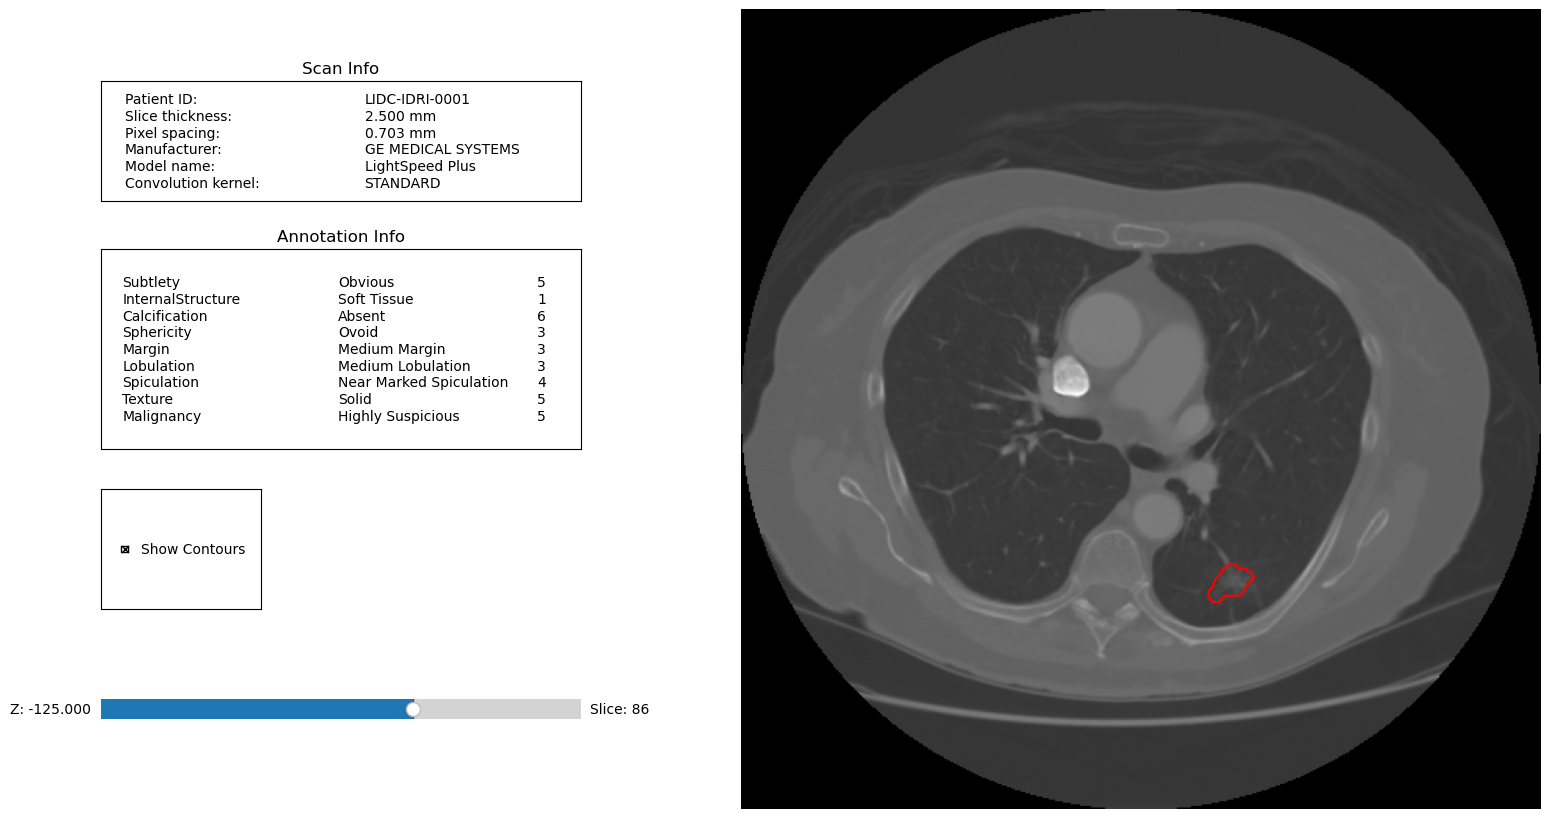


=== Annotation 2/4 ===
Loading dicom files ... This may take a moment.


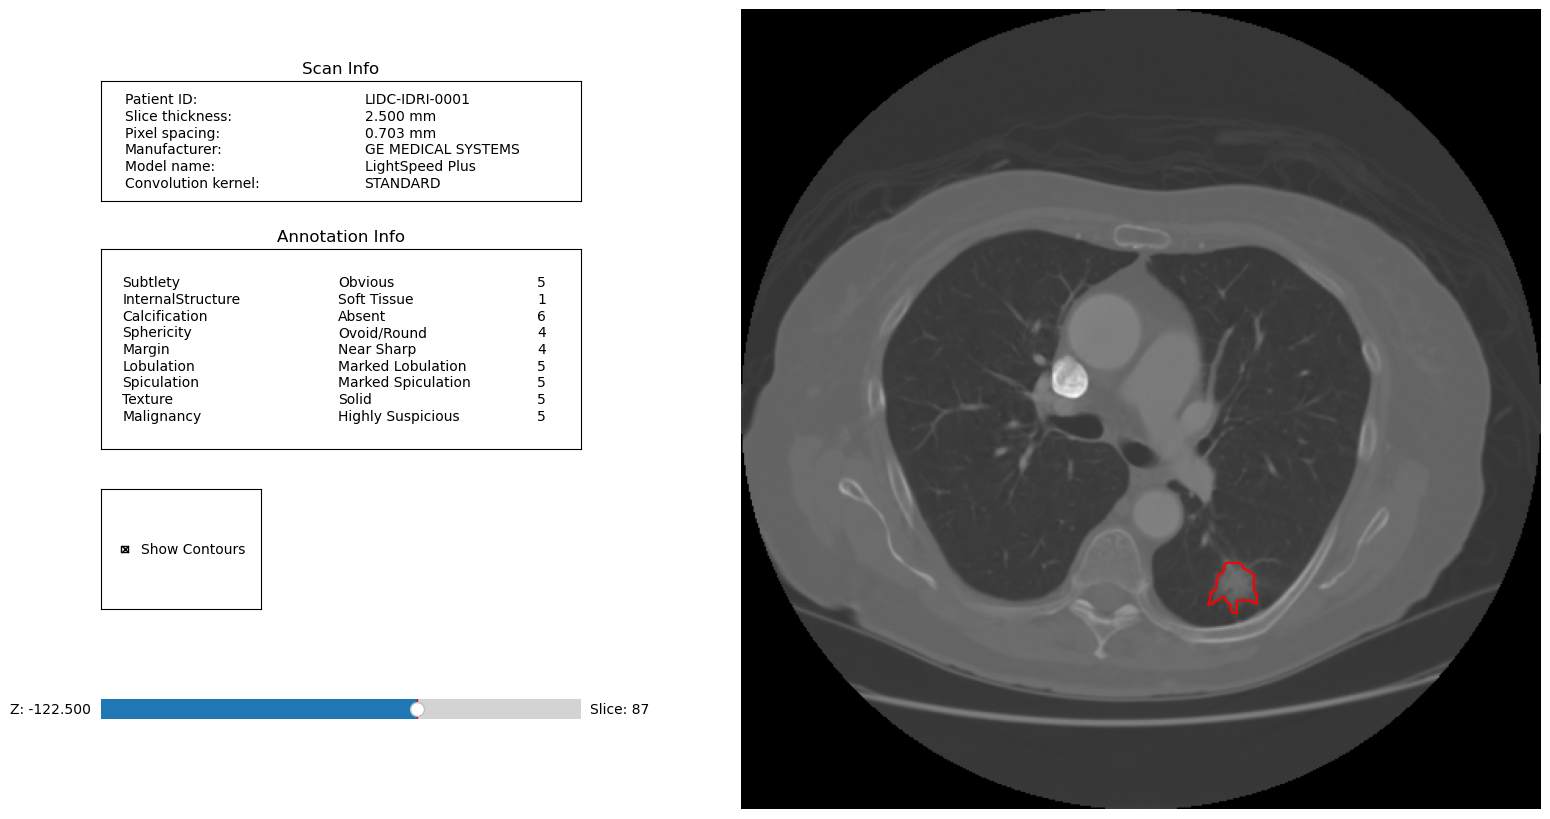


=== Annotation 3/4 ===
Loading dicom files ... This may take a moment.


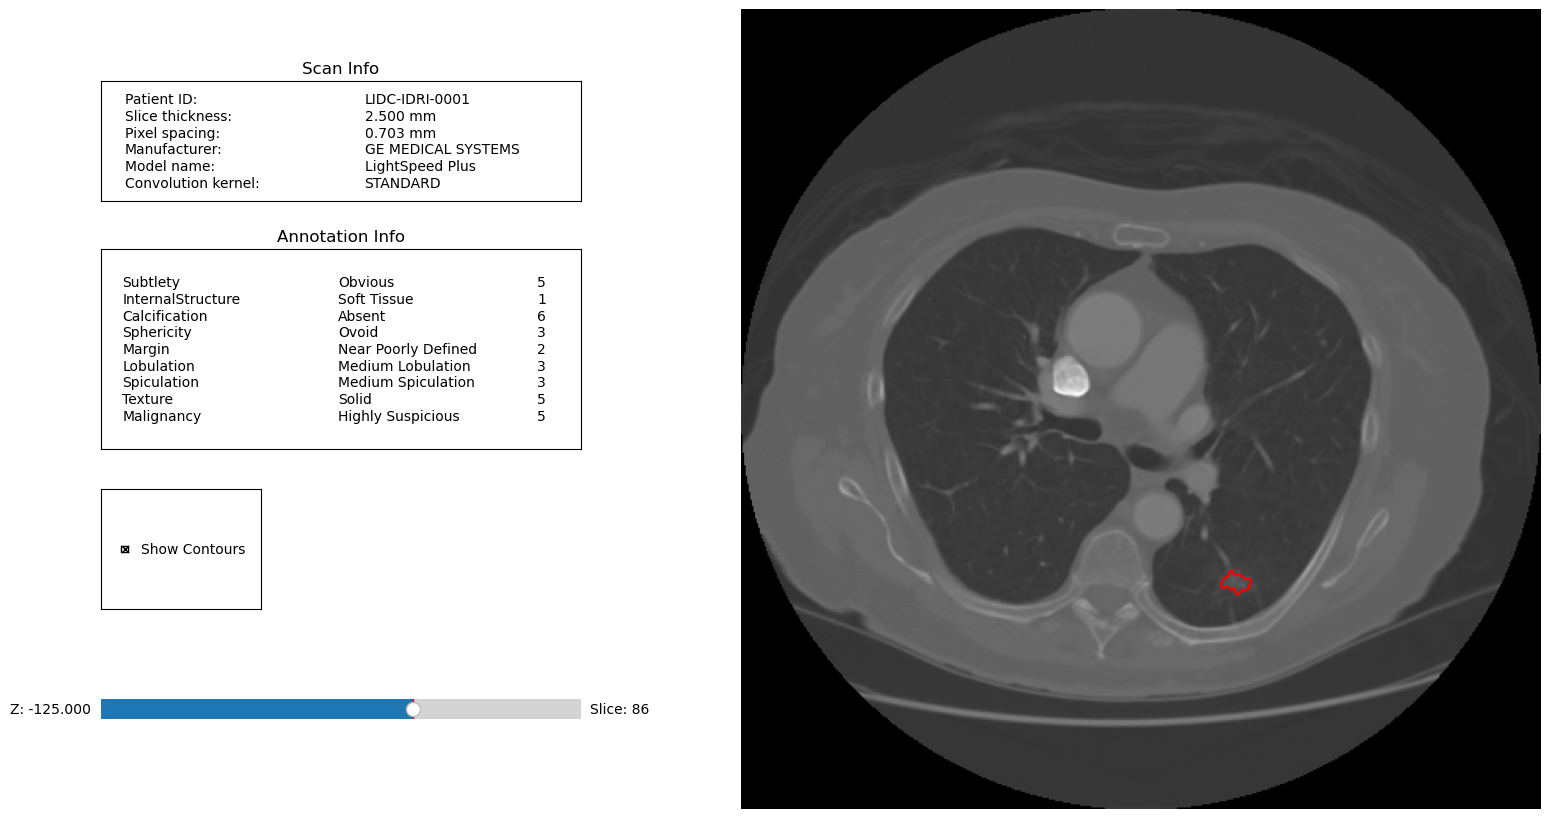


=== Annotation 4/4 ===
Loading dicom files ... This may take a moment.


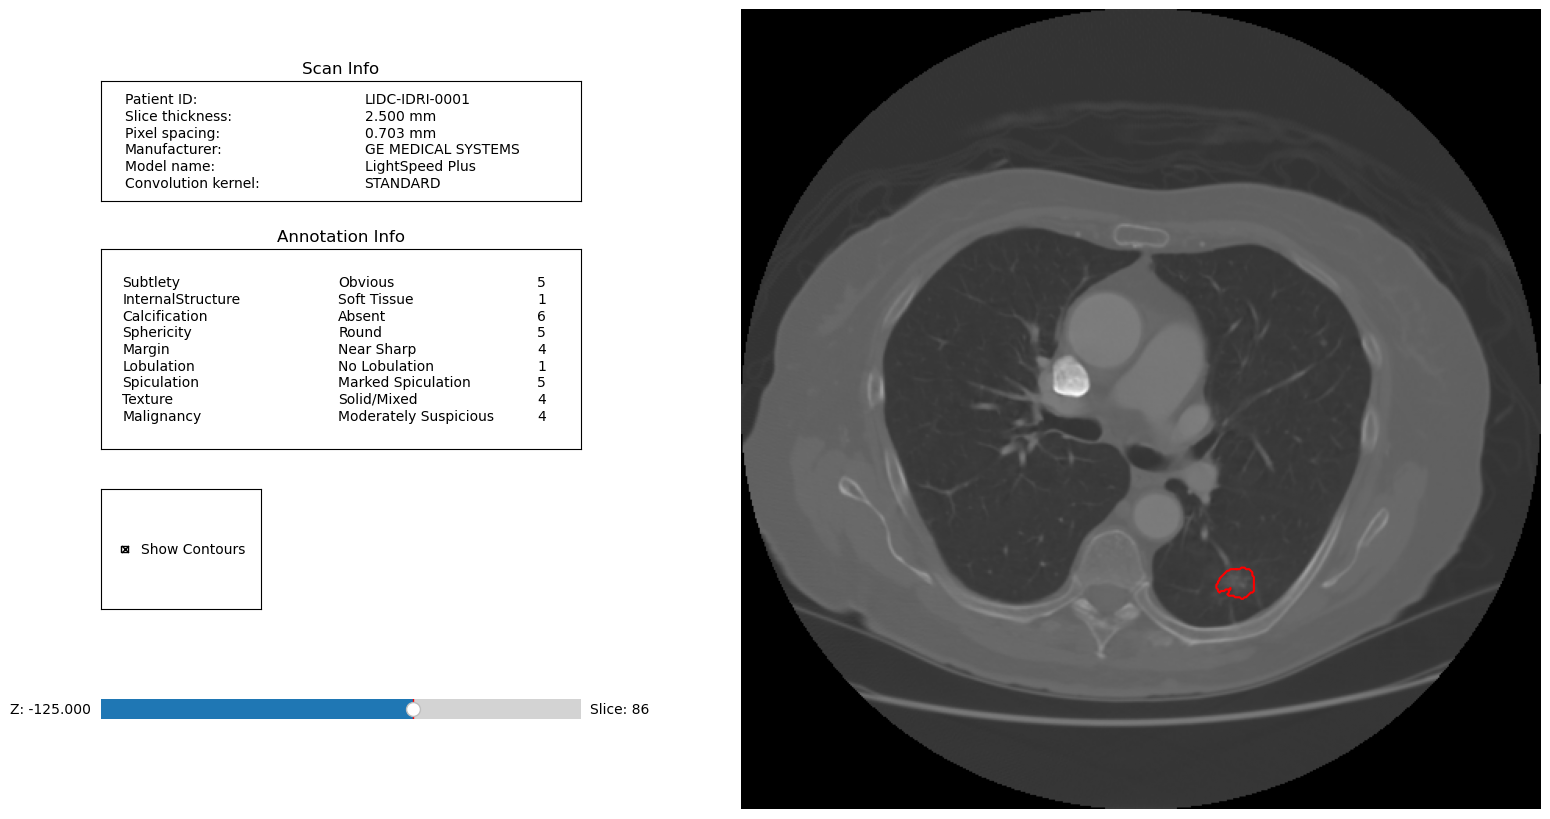

In [102]:
%matplotlib inline

# Select scan by patient ID
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == "LIDC-IDRI-0001").first()

if not scan:
    raise ValueError("No scan found for patient LIDC-IDRI-0366")

anns = scan.annotations
print(f"Found {len(anns)} annotations for patient {scan.patient_id}")

for i, ann in enumerate(anns, 1):
    print(f"\n=== Annotation {i}/{len(anns)} ===")
    ann.visualize_in_scan()
    plt.show()